# Introductory applied machine learning (INFR10069)

# Assignment 4: Feature Engineering

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.


## Mechanics

Fill out this notebook, save it, and **submit it electronically as described below.**

On a DICE environment, open the terminal, navigate to the location of this notebook, and submit this notebook file using the following command:

`submit iaml cw2 09_Assignment_4.ipynb`

What actually happens in the background is that your file is placed in a folder available to markers. If you submit a file with the same name into the same location, **it will *overwrite* your previous submission**. You can check the status of your submissions with the `show_submissions` command.

**Distance Learners:** To copy your work up to DICE (such that you can use the `submit` command) you can use `scp` or `rsync` (you may need to install these yourself). You can copy files up using `student.ssh.inf.ed.ac.uk`, then ssh in to submit, e.g. (in a unix terminal):
```
filename=09_Assignment_4.ipynb
local_scp_filepath=~/git/iaml2017/${filename}
UUN=s0816700
server_address=student.ssh.inf.ed.ac.uk
scp -r ${local_scp_filepath} ${UUN}@${server_address}:${filename}
# rsync -rl ${local_scp_filepath} ${UUN}@${server_address}:${filename}
ssh ${UUN}@${server_address}
ssh student.login
submit iaml cw1 09_Assignment_4.ipynb
```

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).

**Resubmission:** If you submit your file again, the previous submission is **overwritten**. We will mark the version that is in the submission folder at the deadline.

## Important Instructions

1. You *MUST* have your environment set up as in the [README](https://github.com/JamesOwers/iaml2017) and you *must activate this environment before running this notebook*:
```
source activate iaml
cd iaml_2017
jupyter notebook
# Navigate to this file
```

1. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers.

1. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

1. **IMPORTANT:** Keep your answers brief and concise. Most written questions can be answered with 2-3 lines of explanation.

## Imports

In this assignment you are asked to import all the packages and modules you will need. Include all required imports and execute the cell below.

In [2]:
from __future__ import print_function, division
%matplotlib inline

In [3]:
# Your code goes here
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB

/home/chienyu/anaconda2/envs/iaml/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Description of the datasets


This assignment is based on two datasets:
1. the 20 Newsgroups Dataset (you should recognise it from Assignment 1)
2. the MNIST digits dataset

### 20 Newsgroups

For convenience, we repeat the description here. This dataset is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware, comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale, soc.religion.christian). 

To save you time and to make the problem manageable with limited computational resources, we preprocessed the original dataset. We will use documents from only 5 out of the 20 newsgroups, which results in a 5-class problem. More specifically the 5 classes correspond to the following newsgroups: 
1. `alt.atheism`
2. `comp.sys.ibm.pc.hardware`
3. `comp.sys.mac.hardware`
4. `rec.sport.baseball`
5. `rec.sport.hockey `

However, note here that classes 2-3 and 4-5 are rather closely related.

**In contrast to Assignment 1**, we have opted to use tf-idf weights ([term frequency - inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf))
for each word instead of the frequency counts. These weights represent the importance of a word to a
document with respect to a collection of documents. The importance increases proportionally to the number
of times a word appears in the document and decreases proportionally to the number of times the word
appears in the whole corpus. 

Additionally we preprocess the data to include the most frequent 1000 words that are in greater than 2 documents, less than half of all documents, and that are not [stop words](https://en.wikipedia.org/wiki/Stop_words).

We will perform all this preprocessing for you.


### MNIST
This MNIST Dataset is a collection handwritten digits. The samples are partitioned (nearly) evenly across the 10 different digit classes {0, 1, . . . , 9}. We use a preprocessed version for which the data are $8 \times 8$ pixel images containing one digit each. For further details on how the digits are preprocessed, see the sklearn documentation. The images are grayscale, with each pixel taking values in {0, 1, . . . , 16}, where 0 corresponds to black (weakest intensity) and 16 corresponds to white (strongest intensity). Therefore, the dataset is a N × 64
dimensional matrix where each dimension corresponds to a pixel from the image and N is the number of
images. 

Again, to save you time, we perfom the import for you.

## 1. Clustering the 20 Newsgroups Data [50%]

In part 1 we will cluster the observations in the 20 Newsgroups dataset using the k-means algorithm. Each row of the dataset represents a document with bag of words features. If we were not given the labels for each document (i.e. the newsgroup it came from), clustering could allow us to infer which documents should have the same label. Observing common words within each cluster may allow us to give meaning to these inferred labels too.

First we'll import the data and fit and evaluate k-means with 5 cluster centres. Next, we will try and infer which cluster corresponds with which label. Finally, we will pretend we don't know the number of clusters there should be, as is the normal scenario with large unlabeled data, and investigate the effect of using a different number of cluster centres (i.e. varying `k`).

### ========== Question 1.0 --- [0 marks] ==========

Run the below cells to import the data. It would be a good idea to understand the code but it's not strictly necessary (see the [sklearn documentation](http://scikit-learn.org/0.17/datasets/index.html#the-20-newsgroups-text-dataset)).

*This may take a wee while as it will download the dataset*

**Do not change any of the code in this question**

In [4]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
cats = ['alt.atheism', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 
        'rec.sport.baseball', 'rec.sport.hockey']
newsgroups_train = fetch_20newsgroups(subset='train', categories=cats, 
                                      remove=('headers', 'footers', 'quotes'))
vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000,
                             min_df=2, stop_words='english', 
                             token_pattern='(?u)\\b[A-z]{2,}\\b')
X_sparse = vectorizer.fit_transform(newsgroups_train.data)
y_num = newsgroups_train.target
X = pd.DataFrame(X_sparse.todense(), columns=vectorizer.get_feature_names())
y = np.array(cats)[y_num]


### ========== Question 1.1 --- [5 marks] ==========

Perform an initial inspection of the data, X and y (no more than 5 lines of code). Below the code, describe what the data are i.e. what the objects are, and what they represent (fewer than 4 sentences).

In [6]:
# Your code goes here
print('Number of instances: {}, number of attributes: {}'.format(X.shape[0], X.shape[1]))
X.describe()

Number of instances: 2845, number of attributes: 1000


,abc,ability,able,ac,accept,access,according,acquired,actually,adaptec,...,written,wrong,yankees,yeah,year,years,yes,york,young,zone
count,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,...,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000
mean,0.002436,0.002149,0.006709,0.001454,0.002286,0.003953,0.003115,0.000921,0.008366,0.001816,...,0.002612,0.006811,0.002470,0.003564,0.016934,0.008797,0.006381,0.002772,0.003288,0.001626
std,0.030224,0.020739,0.034631,0.023100,0.021634,0.030111,0.026958,0.016275,0.043921,0.026026,...,0.026988,0.039172,0.032786,0.031238,0.061181,0.039346,0.037319,0.025381,0.030929,0.022175
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.723914,0.420916,0.431380,0.519765,0.443354,0.663808,0.572124,0.413233,1.000000,0.578282,...,0.723081,0.568146,0.878185,0.693531,0.650649,0.455493,0.646447,0.572455,0.703771,0.605576


*Your answer goes here*

There are 2845 data set with 1000 features(word).These word represent the importance of the word in each document. 

### ========== Question 1.2 --- [2 marks] ==========

Initialise a [k-means clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) object with 5 clusters. Make sure that you can reproduce your results exactly. *Hint: there is an argument for this*. You need only set two arguments; others can be kept as default. Call the instantiated object `kmeans`. Use the `fit()` method to fit to the training data (X imported above)

In [7]:
# Your code goes here
rng = np.random.seed(0)
kmeans = KMeans(n_clusters=5, random_state=rng).fit(X)


### ========== Question 1.3 --- [6 marks] ==========

Evauate the quality of this fit.

1. Get a feel for the average distance of a data point from the centre: print the mean of the euclidean distances of all data points from the mean data point (in the whole dataset)
1. print the inertia of the model. *Hint: check the properties of the kmeans object*
1. print the adjusted rand index of the model. *Hint: `adjusted_rand_score`*

Below the code: 
1. Define what the inertia and adjusted rand score are (one or two sentences). *Hint: check [sklearn documentation](http://scikit-learn.org/stable/modules/clustering.html)*
1. Comment on the quality of the clustering implied by the adjusted rand score and inertia

In [10]:
# Your code goes here
print("mean:",(np.sum(np.sqrt(np.sum(((X-X.mean())**2).T)).T))/2845)
print('inertia: {}\nadjusted_rand_score: {}'.format(kmeans.inertia_, adjusted_rand_score(y, kmeans.labels_)))

mean: 0.954584949852
inertia: 2593.26745106
adjusted_rand_score: 0.236459358529


*Your answer goes here*

Inertia can be recognized as a measure of how internally coherent clusters are, which is the sum of distances of each data point to their closest cluster center.

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

the adjusted_rand_score score of 1 means perfectly matching labelings, however we only get 0.2. Also the sum of distances of each point to their closet cluster center is quite big. Overall, the model of kmeans is not that perfect.

### ========== Question 1.4 --- [3 marks] ==========

Print:
1. the number of datapoints with each label
2. the number of datapoints assigned to each cluster. *Hint: you should use the properties of the kmeans object you just fit.* 

Below the code, comment on the distribution of datapoints to cluster centres.

In [260]:
# Your code goes here
label_count = np.unique(y,return_counts=True)
print("the number of datapoints with each label:")
for i in range(5):
    print(label_count[0][i],":",label_count[1][i])

unique, counts = np.unique(kmeans.labels_, return_counts=True)
print("\nthe number of datapoints with each cluster", dict(zip(unique+1,counts)))


the number of datapoints with each label:
alt.atheism : 480
comp.sys.ibm.pc.hardware : 590
comp.sys.mac.hardware : 578
rec.sport.baseball : 597
rec.sport.hockey : 600

the number of datapoints with each cluster {1: 1028, 2: 221, 3: 307, 4: 601, 5: 688}


*Your answer goes here*

The datapoints are divided to 5 clusters. There are 1028 data points assigned to the biggest cuslter. The other two clusters own around 600 data points. The rest of the two cluster have about 200 and 300 data points, respectively.

### ========== Question 1.5 --- [3 marks] ==========

We can't visualise these cluster centres directly, since they are 1000 dimensional. However, we can at least measure the distance between each centre. Create a distance matrix such that the entry with index (i,j) shows the distance between centre i and j. *Hint: again you should use the properties of the kmeans object you just fit.*

In [261]:
# Your code goes here
def _distance(p1,p2):
        """
        Return Eclud distance between two points.
        p1 = np.array([0,0]), p2 = np.array([1,1]) => 1.414
        """
        tmp = np.sum((p1-p2)**2)
        return np.sqrt(tmp)
center = kmeans.cluster_centers_
#mean = np.mean(center, axis=1)
index = []
for i in range(5):
    a = []
    for j in range(5):
        a.append(_distance(center[i],center[j]))
    index.append(a)
print(index)


[[0.0, 0.34374520806212416, 0.23330485429691311, 0.20265703207211694, 0.18763549005402125], [0.34374520806212416, 0.0, 0.41216403530254325, 0.40767880491228198, 0.32073454332936085], [0.23330485429691311, 0.41216403530254325, 0.0, 0.29943647270509161, 0.29271356814685279], [0.20265703207211694, 0.40767880491228198, 0.29943647270509161, 0.0, 0.28842491471938658], [0.18763549005402125, 0.32073454332936085, 0.29271356814685279, 0.28842491471938658, 0.0]]


### ========== Question 1.6 --- [3 marks] ==========

For each cluster centre label, plot the counts of the true labels. The cluster labels are a property of the k-means object, the true labels are contained in `y`. Make sure that you label the plot axes and legend clearly. Below the code, comment on the quality of the fit. *Hint: you can do the main plot (without labels) in one line with seaborn (you're free to do it as you like though!).*

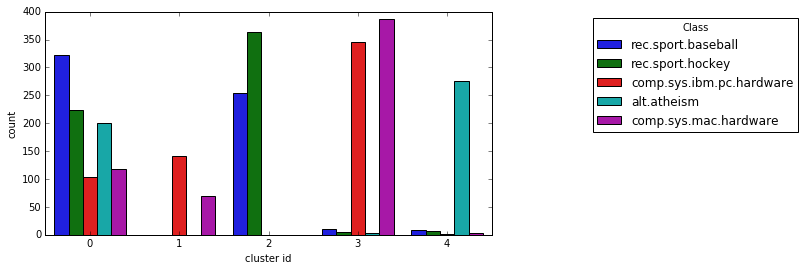

In [53]:
# Your code goes here
ig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=kmeans.labels_, hue=y, ax=ax)
ax.legend( bbox_to_anchor=[1.7, 1], title='Class')
plt.xlabel('cluster id')
plt.show()

*Your answers goes here*

All of the classes have datapoints in cluster 0, and rec.sport.baseball is slightly higher than the others.

In cluster 1, most of the datapoints are from comp.sys.ibm.pc.hardware and comp.sys.mac.hardware, which is same as the final cluster. It is clear that they are very closely related to each other.

In cluster 2, we can see that most of the datapoints are from alt.atheism.

In the next cluster, the data points are from rec.sport.baseball and rec.sport.hockey, they are closely related to each other too.

Overall, we can find that there are two groups highly related to each other, thus it is hard to cluster between them.

### ========== Question 1.7 --- [8 marks] ==========

We will now investigate using dimensionality reduction to try and improve the quality of the fit. Use the sklearn implementation of [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and its method `fit_transform()` to create a reduced reduced dataset for `n_components` = [1,2,3,5,10,20,50,100,500,1000] i.e. create datasets that are of shape `(N, d)` for `d` in `n_components`. Fit k-means to each reduced dataset and report the `inertia` and `adjusted_rand_score` for each iteration.

Plot `adjusted_rand_score` against number of principal components (label graph). Use a log scale on the x axis. Below the graph:
1. describe what it shows
1. explain why we cannot use inertia to choose the best number of principal components
1. explain why dimensionality reduction could help k-means perform better

number of component 1:
inertia: 2.8225803688
adjusted_rand_score: 0.210726735258

number of component 2:
inertia: 10.5825586932
adjusted_rand_score: 0.267804341567

number of component 3:
inertia: 20.6771175913
adjusted_rand_score: 0.240984421965

number of component 5:
inertia: 49.6996922719
adjusted_rand_score: 0.230598431682

number of component 10:
inertia: 117.915516728
adjusted_rand_score: 0.215747392342

number of component 20:
inertia: 230.853611366
adjusted_rand_score: 0.216430863325

number of component 50:
inertia: 487.911324196
adjusted_rand_score: 0.22075523435

number of component 100:
inertia: 800.452879841
adjusted_rand_score: 0.212296520645

number of component 500:
inertia: 2132.10907302
adjusted_rand_score: 0.219179100607

number of component 1000:
inertia: 2593.15308069
adjusted_rand_score: 0.229354463163



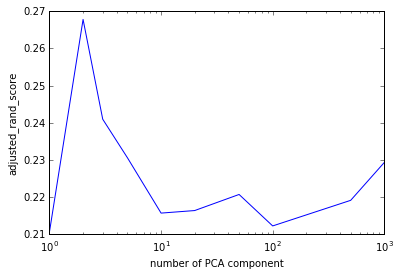

In [33]:
# Your code goes here
components = [1,2,3,5,10,20,50,100,500,1000]
ars = []
inertia = []
for i in components:
    pca = PCA(n_components = i)
    X_2d = pca.fit_transform(X)
    newkmeans = kmeans.fit(X_2d)
    ars.append(adjusted_rand_score(y, newkmeans.labels_))
    inertia.append(newkmeans.inertia_)
    print('number of component {}:'.format(i))
    print('inertia:',newkmeans.inertia_)
    print('adjusted_rand_score:',adjusted_rand_score(y, newkmeans.labels_))
    print('')

plt.plot(components,ars)
plt.xlabel('number of PCA component')
plt.ylabel('adjusted_rand_score')
plt.xscale('log')
plt.show()


*Your answer goes here*

1. While the number of component increase, the in inertia become higher. The graph shows the fluctuation in the value of adjusted_rand_score, the highest point is in 2 component around 0.27.

2. The reason why we cannot choose the best number of principal components by inertia is that it will increase when the number of components become bigger. And, in high-dimensional spaces, inertia tends to become very high. However, we need a lower inertia, zero is the best. 

3. Dimensionality reduction retained the most important variance of the data and remove multi-collinearity in the data set. Thus, it could help k-means perform better. 

### ========== Question 1.8 --- [6 marks] ==========

1. So we can visualise the data, create X_2d: the dataset X transformed down to 2 principal component dimensions. Use sklearn's implementation of [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and its method `fit_transform()` to do this (as above). 

1. Create a new k-means object, `kmeans_pca`, and fit the 2d data to it. Show the adjusted rand score.

1. As above, for each cluster centre label, plot the counts of the true labels. The cluster labels are a property of the k-means object, the true labels are contained in `y`. Make sure that you label the plot axes and legend clearly. Print below it the number of data points each cluster is responsible for.

1. Finally, below the plot, comment on the difference between these clusters and the clusters on the 1000 dimensional data with respect to the distribution of the labels in each. Are they better?

adjusted_rand_score: 0.267938382874


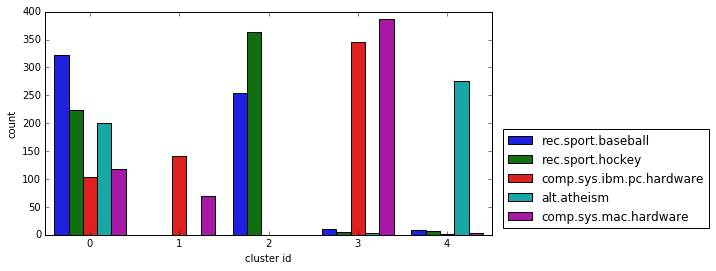

In [50]:
# Your code goes here
pca_new = PCA(n_components=2).fit_transform(X)
kmeans_pca = kmeans.fit(pca_new)
print("adjusted_rand_score:", adjusted_rand_score(y, kmeans_pca.labels_))

fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=kmeans_pca.labels_, hue=y, ax=ax)
ax.legend( bbox_to_anchor=[1.5, 0.5])
plt.xlabel('cluster id')
plt.show()

*Your answer goes here*

PCA only perform slightly better, I would say there are no big difference between them.
The two similar groups are still hard to assign each class to different clusters.

### ========== Question 1.9 --- [1 mark] ==========

Given the above plot, apply a label to each cluster centre. Create a new vector, `labels_interp`, which is the same as `kmeans.labels_`, but instead of numbers, the interpreted label of the cluster centre. For example, if you decided cluster 0 was 'apples', 1 was 'pears', 2 was 'stairs', and `kmeans.labels_` was `[2, 0, 1, 1, 0]`, create  `labels_interp = ['stairs', 'apples', 'pears', 'pears', 'apples']`. Hint: an example of how to do this is given in the last line of Question 1.0.

**N.B. be careful to use the `kmeans_pca` object you created above, not the first kmeans object you made**

In [106]:
# Your code goes here
cats2 = ['rec.sport.baseball','comp.sys.ibm.pc.hardware','rec.sport.hockey','alt.atheism','comp.sys.mac.hardware']
labels_interp = np.array(cats2)[kmeans_pca.labels_]
print(labels_interp)
print(kmeans.labels_)

['rec.sport.baseball' 'rec.sport.hockey' 'rec.sport.hockey' ...,
 'comp.sys.mac.hardware' 'rec.sport.hockey' 'rec.sport.baseball']
[0 2 2 ..., 4 2 0]


### ========== Question 1.10 --- [3 marks] ==========

Produce a normalised (by true label) confusion matrix of your interpreted labels from the k-means clustering and the true labels. As usual, you may use any functions from previous assignments or labs. Clearly label the axes of the plot. Check that these confusions correlate with your expectations! N.B. this is just a slightly different way of interpreting the information in the count plot above (focussed this time on the true labels).

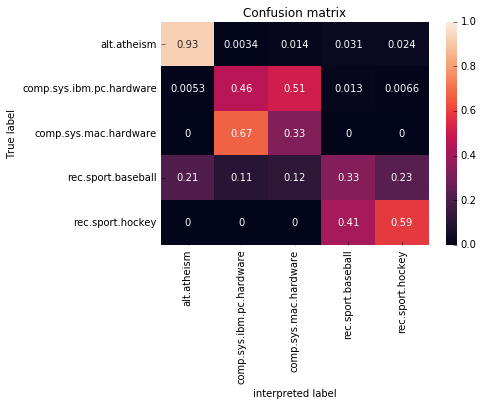

In [274]:
# Your code goes here
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('interpreted label')

cm = confusion_matrix(labels_interp, y)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=cats)

### ========== Question 1.11 --- [6 marks] ==========

Since we are now in 2 dimensions, let's visualise the data, the cluster centres, and the decision boundaries via a [Voronoi_diagram](https://en.wikipedia.org/wiki/Voronoi_diagram). You'll essentially be able to copy and paste the code from the [sklearn kmeans digits example](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) and edit a few bits to get over half marks.

Clearly mark each cluster centre.

For full marks, additionally:
* label each cluster centre with the inferred cluster label
* create a second plot which clearly shows where the true classes lie within the pca space e.g. the [sklearn PCA example here](http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html)

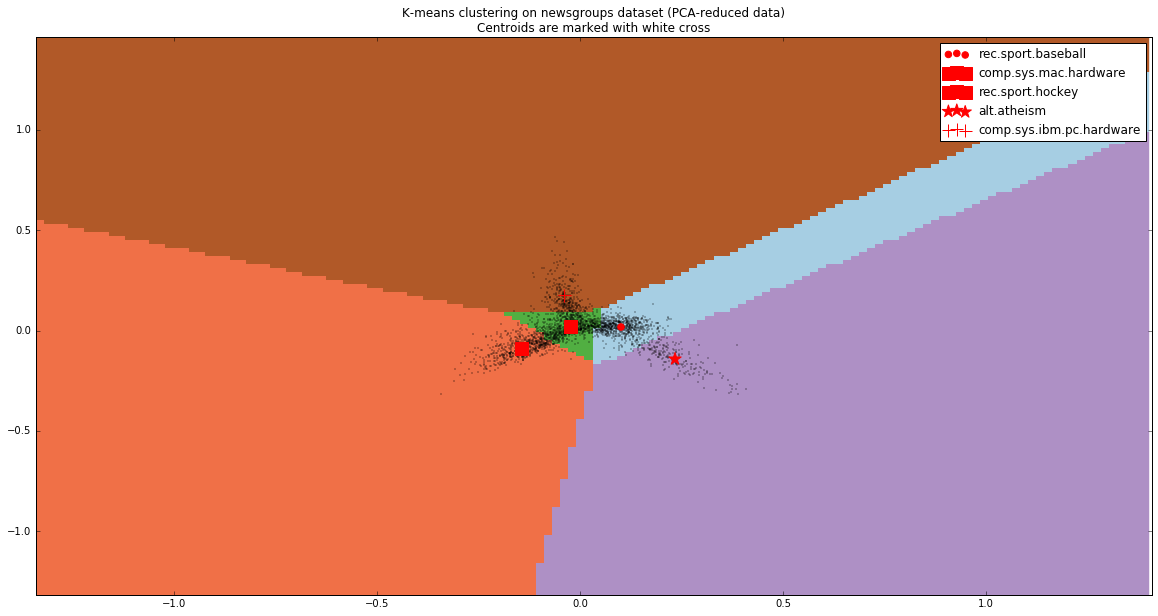

In [207]:
# #############################################################################
# Visualize the results on PCA-reduced data
pca = PCA(n_components = 2)
X_2d = pca.fit_transform(X)
reduced_data = X_2d
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1,figsize=(20,10))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=1)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[0:1, 0], centroids[0:1, 1], marker='.', label='rec.sport.baseball', s=169, linewidths=1, color='r', zorder=10)
plt.scatter(centroids[1:2, 0], centroids[1:2, 1], marker=',', label='comp.sys.mac.hardware', s=169, linewidths=1, color='r', zorder=10)
plt.scatter(centroids[2:3, 0], centroids[2:3, 1], marker='s', label='rec.sport.hockey', s=169, linewidths=1, color='r', zorder=10)
plt.scatter(centroids[3:4, 0], centroids[3:4, 1], marker='*', label='alt.atheism', s=169, linewidths=1, color='r', zorder=10)
plt.scatter(centroids[4:5, 0], centroids[4:5, 1], marker='+', label='comp.sys.ibm.pc.hardware', s=169, linewidths=1, color='r', zorder=10)
#cats = ['rec.sport.baseball','comp.sys.mac.hardware','rec.sport.hockey','alt.atheism','comp.sys.ibm.pc.hardware']


plt.title('K-means clustering on newsgroups dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())
plt.show()



explained variance ratio (first two components): [ 0.01428681  0.00902764]


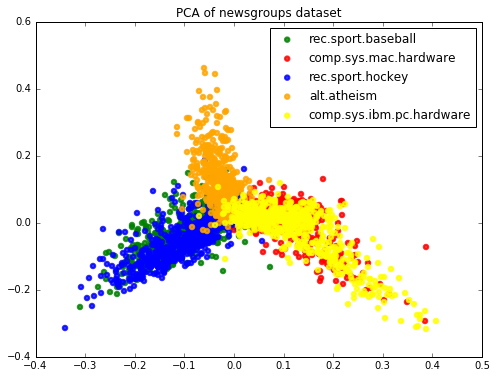

In [241]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X = X_2d
y = y
target_names = ['rec.sport.baseball','comp.sys.mac.hardware','rec.sport.hockey','alt.atheism','comp.sys.ibm.pc.hardware']
                
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure(figsize=(8,6))
colors = ['green', 'red', 'blue', 'orange', 'yellow']
lw = 2

for color, i, target_name in zip(colors, ['rec.sport.baseball','comp.sys.mac.hardware','rec.sport.hockey','alt.atheism','comp.sys.ibm.pc.hardware'], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
    #print(X_r[y == i, 0])
    #print(y)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of newsgroups dataset')
plt.show()


### ========== Question 1.12 --- [4 marks] ==========

*Write a **1 or 2 sentence** answer for each question*.

1. Is the kmeans algorithm deterministic?
1. Did the algorithm you ran above in Question 1.2 (fitting k-means) do multiple initialisations? If not, explain why it was not necessary. If so, how was the final model selected?
1. The default method for initialising centres in the sklearn implementation is [kmeans++](https://en.wikipedia.org/wiki/K-means%2B%2B). Name another method for initialising and a problem with it.

*Your answer goes here*

1. Yes, although it will be effected by the first initialisation.

2. Yes, the algorithm will run multiple initialisations to determine an appropriate cluster center. When euclidean distances of all data points to the cluster center is smaller than a particular threshold it will stop.

3. Random is another method for initialising the centers, the problem may arise is that kmeans will be sensitive to the choices of first initialisations.

## 2. PCA with MNIST Data [50%]

In the second part of the assignment we will explore the MNIST digits dataset. We expect the digits to lie in a lower-dimensional manifold and want to examine the representation we get by applying Principal Components Analysis (PCA). PCA maps the data into a new space by effectively rotating the base vectors of the input space to the directions with the highest variance. We will assess the impact of this mapping to the classification task and the separability of the data in the PCA space.

### ========== Question 2.0 --- [0 marks] ==========

Run the cell below to load the digits object and print its description.

**Do not change any of the code in this question**

In [4]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.DESCR)

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

### ========== Question 2.1 --- [8 marks] ==========

If you execute `digits.keys()`, you'll see this object contains the data, the targets (the labels), and the images (the data reshaped to 8x8 images). More typically the mnist data are [28x28 images](http://yann.lecun.com/exdb/mnist/), but this is a preprocessed version. 

1. Use the pandas describe method on the data to get a feel for the range of each dimension
1. What are the max/min values for each dimension?
1. Extract the standard deviations from the output of the describe method (just another DataFrame with 'std' as one of the index values), reshape to an 8x8 image, and plot a heatmap (use `sns.heatmap()`) to show you which dimensions vary the most. For a bonus mark, produce a plot like this for each digit. *Hint: you can use `.groupby(digits.target)` before calling `.describe()`*.
1. Use `sns.heatmap()` to plot the first 9 digits in the dataset

Below the plots, answer this question in a markdown cell:
1. Are all of the dimensions going to be equally helpful for modelling? Explain.

In [5]:
# Your code goes here
print(digits.keys())
data_df = pd.DataFrame(digits.data)
print(data_df.describe())

['images', 'data', 'target_names', 'DESCR', 'target']
           0            1            2            3            4   \
count  1797.0  1797.000000  1797.000000  1797.000000  1797.000000   
mean      0.0     0.303840     5.204786    11.835838    11.848080   
std       0.0     0.907192     4.754826     4.248842     4.287388   
min       0.0     0.000000     0.000000     0.000000     0.000000   
25%       0.0     0.000000     1.000000    10.000000    10.000000   
50%       0.0     0.000000     4.000000    13.000000    13.000000   
75%       0.0     0.000000     9.000000    15.000000    15.000000   
max       0.0     8.000000    16.000000    16.000000    16.000000   

                5            6            7            8            9   \
count  1797.000000  1797.000000  1797.000000  1797.000000  1797.000000   
mean      5.781859     1.362270     0.129661     0.005565     1.993879   
std       5.666418     3.325775     1.037383     0.094222     3.196160   
min       0.000000     0.000

In [58]:
print(data_df.describe().loc[['max','min']])

      0    1     2     3     4     5     6     7    8     9   ...     54  \
max  0.0  8.0  16.0  16.0  16.0  16.0  16.0  15.0  2.0  16.0  ...   16.0   
min  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0  ...    0.0   

       55   56   57    58    59    60    61    62    63  
max  13.0  1.0  9.0  16.0  16.0  16.0  16.0  16.0  16.0  
min   0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[2 rows x 64 columns]


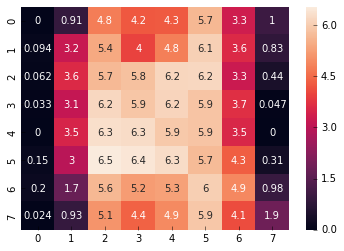

In [59]:
std = data_df.describe().loc[['std']].values.reshape(8,8)
ax = sns.heatmap(std, annot=True)

/home/chienyu/anaconda2/envs/iaml/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


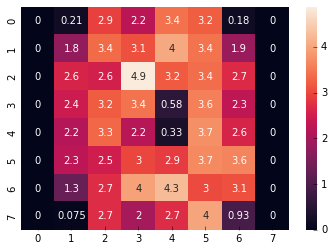

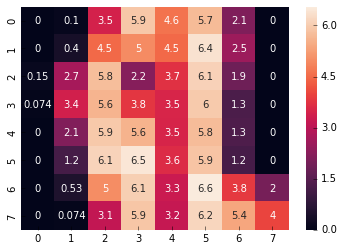

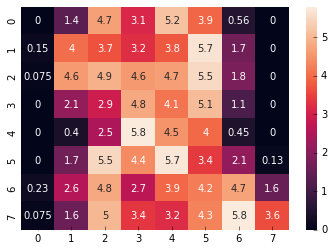

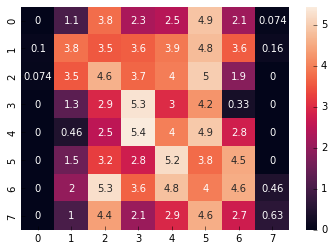

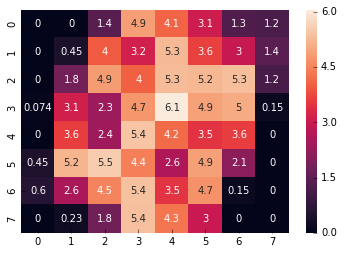

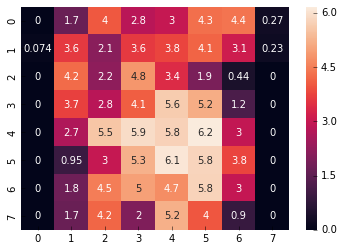

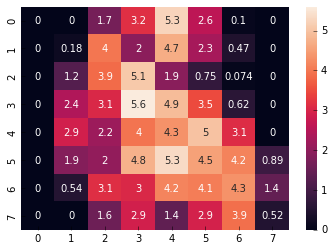

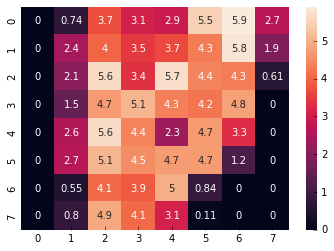

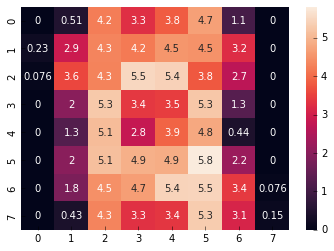

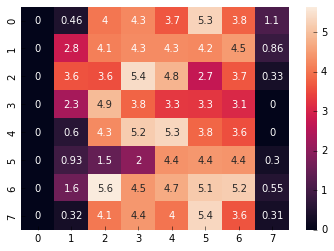

In [10]:
digit_target =pd.DataFrame(digits.target, columns=['target'])
digit_df = pd.concat([data_df,digit_target], axis=1)
groupx= digit_df.groupby(['target'])
for name, group in groupx:
    plt.figure()
    heatmap_data = pd.DataFrame(group).drop("target",axis=1).std().reshape(8,8)
    ax = sns.heatmap(heatmap_data, annot=True)

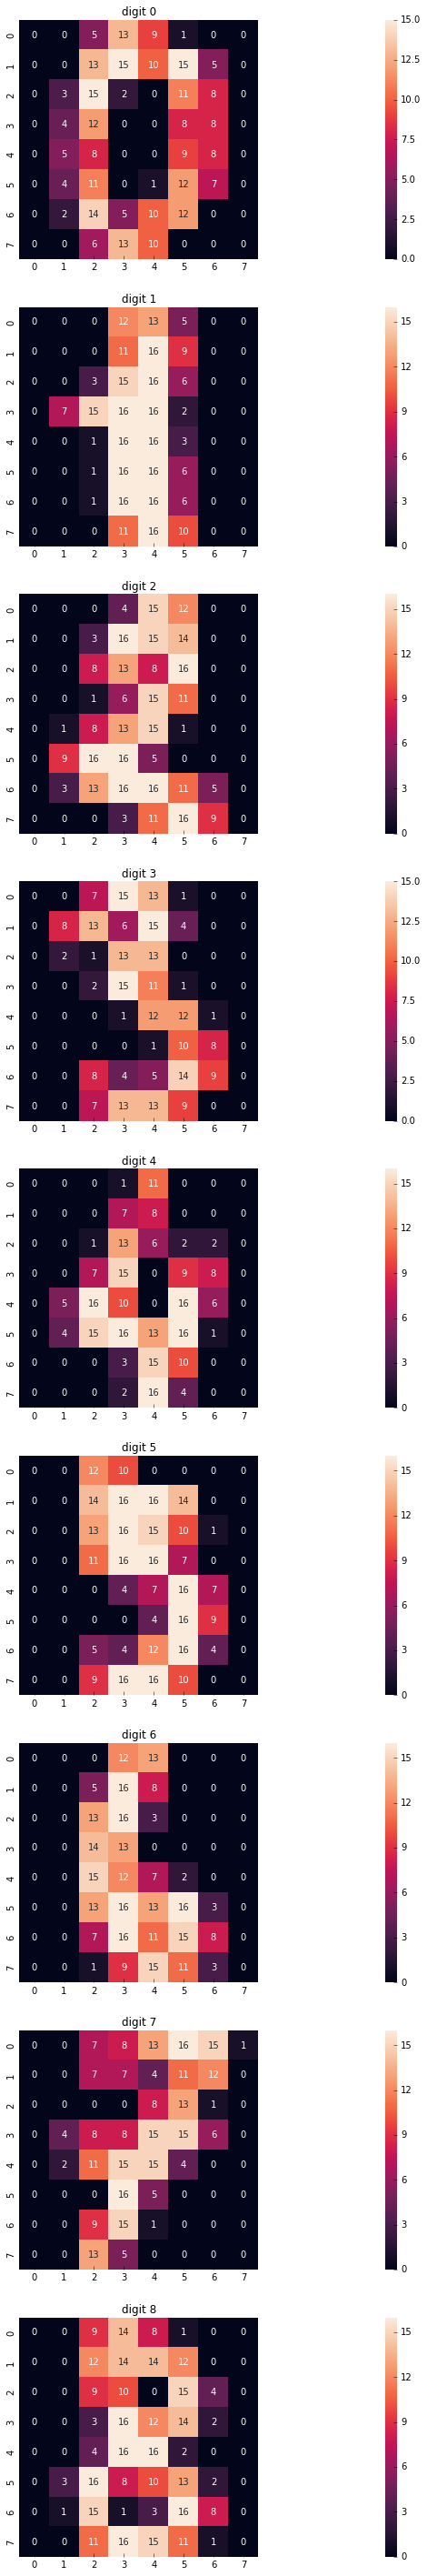

In [60]:
f, ax = plt.subplots(figsize=(50,50),nrows=9)
for i in range(9):   
    ax[i] = sns.heatmap(data_df.iloc[i,:].values.reshape(8,8),annot=True, ax=ax[i], square=True)
    ax[i].set_title('digit {}'.format(i))

*Your answer goes here*

Not all of these dimensions are equally helpful in modeling, some dimensions remains unchanged (always equal to zero) and are helpless for modeling.

### ========== Question 2.2 --- [10 marks] ==========

Create a new `PCA` object with `n_components = digits.data.shape[1]`. Plot the explained variance **ratio** against the number of components. You may find [this example](http://scikit-learn.org/stable/auto_examples/plot_digits_pipe.html#sphx-glr-auto-examples-plot-digits-pipe-py) quite handy...

Find the point where 95% of the variance has been explained. Use `plt.vlines()` to add a dotted verical line to the graph at that point and use `plt.annotate()` to label the number of eigenvectors used to explain that variance.

Below the plot, explain what you observe. What does this suggest about the data?

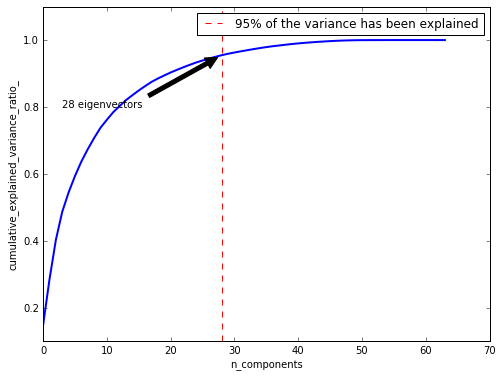

In [7]:
# Your code goes here
pca_B = PCA(n_components=data_df.shape[1]).fit(data_df)
explained_variance_ratio_ = [0]*64 
b=[]
c=[]
for a in range(64):
    explained_variance_ratio_[a] = explained_variance_ratio_[a-1] + pca_B.explained_variance_ratio_[a]
    if explained_variance_ratio_[a] >= 0.95:
        b.append(a) 
        c.append(explained_variance_ratio_[a])
        
# Plot the PCA 
plt.figure(figsize=(8,6))
plt.clf()
plt.plot(explained_variance_ratio_, linewidth=2)
plt.xlabel('n_components')
plt.ylabel('cumulative_explained_variance_ratio_')
plt.axvline(x = b[0], linestyle='--', color='r', label='95% of the variance has been explained')
plt.annotate('{} eigenvectors'.format(b[0]), xy=(b[0], c[0]), xytext=(3, 0.8),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.legend()
plt.show()

*Your answer goes here*

If we want 95% of the variance,it is 28 dimensions. And, we can project the data to 28 dimensions and still keep the main characteristics of the datasets. 

### ========== Question 2.3 --- [8 marks] ==========

You will find the eigenvectors stored within `pca.components_`. Reuse your code from Question 2.1 and plot the first 9 principal components (PCs). Below, plot `pca.mean_`. 

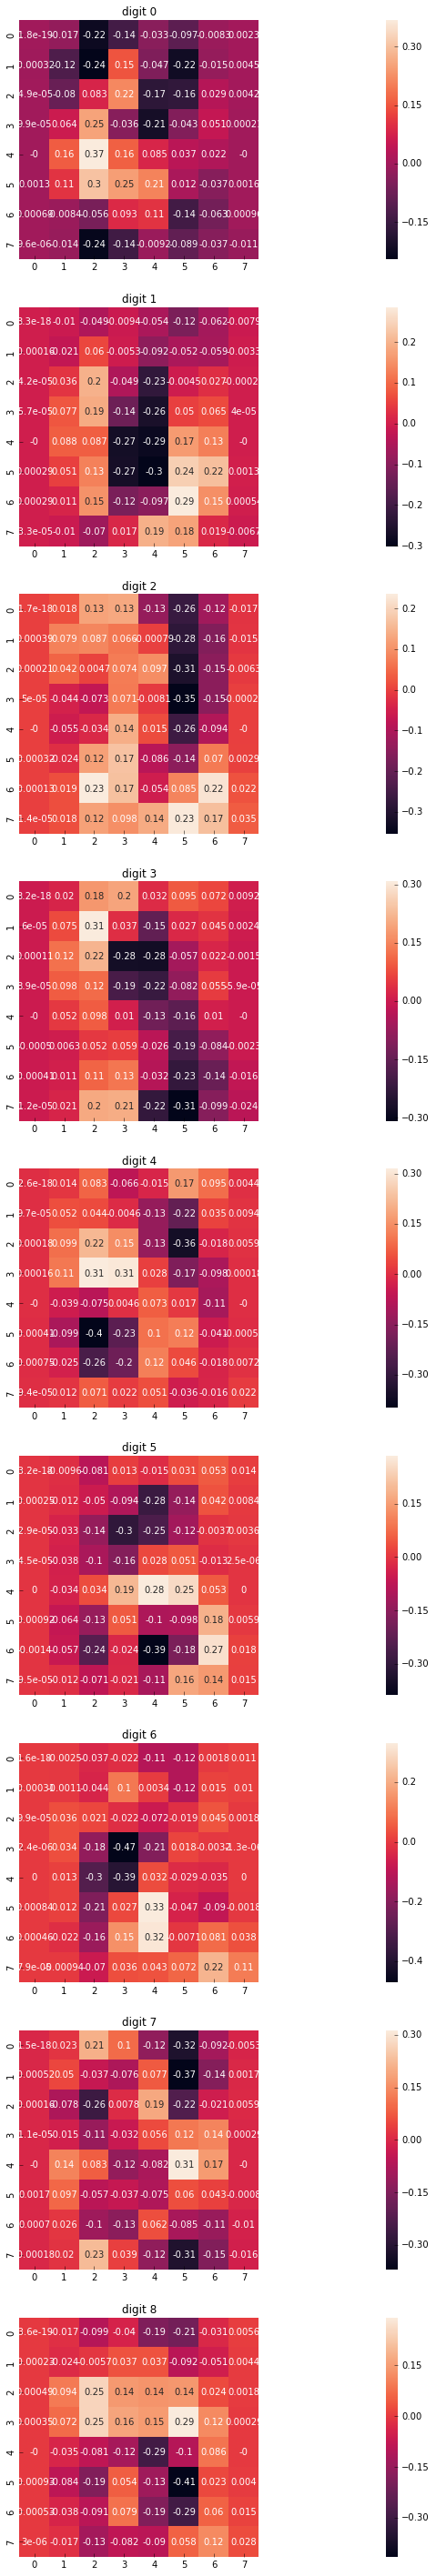

In [157]:
# Your code goes here
f, ax = plt.subplots(figsize=(50,50),nrows=9)
for i in range(9):   
    ax[i] = sns.heatmap(pca_B.components_[i,:].reshape(8,8),annot=True, ax=ax[i], square=True)
    ax[i].set_title('digit {}'.format(i))

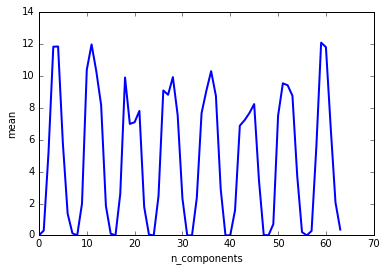

In [158]:
plt.plot(pca_B.mean_, linewidth=2)
plt.xlabel('n_components')
plt.ylabel('mean')
plt.show()

### ========== Question 2.4 --- [10 marks] ==========

Now we want to make clear how these eigenvectors and the mean are used to approximate the data. `pca.transform(digits.data[idx,:].reshape(1, -1)).flatten()` will transform the digit in row `idx` into pca space. Another way to think about this is that it will give you the coefficents to multiply each eigenvector by and to add to the mean digit such that you can reconstruct the digit.

For the digit with idx = 0 (which should itself be a zero), create 4 plots:
1. The original digit
1. The digit reconstructed using 1 principal component
1. The digit reconstructed using 2 principal components
1. The digit reconstructed using 5 principal components

In the plot titles show:
1. the number of principal components used
1. the percentage of variance explained by that number of principal components
1. the coefficients of each principal component rounded to nearest integer (tip, convert to integers to reduce print space), i.e. the PCA space vector.

Below the plots, comment on the result. Do the eigenvectors produce realistic data?

/home/chienyu/anaconda2/envs/iaml/lib/python2.7/site-packages/ipykernel_launcher.py:17: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/home/chienyu/anaconda2/envs/iaml/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()


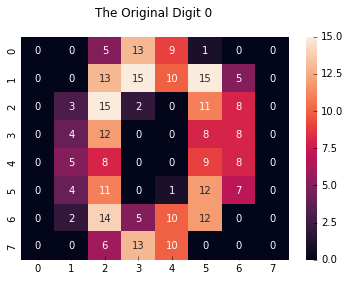

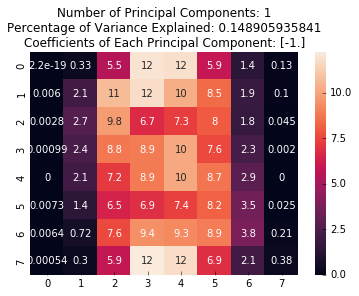

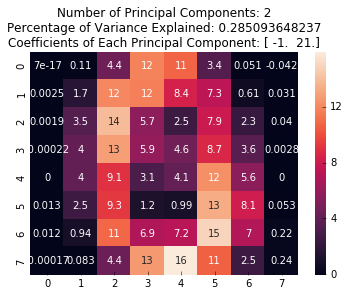

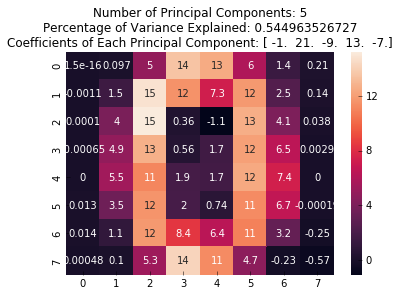

In [31]:
# Your code goes here
pca_digit = PCA(n_components=digits.data.shape[1]).fit(digits.data)
pca_data = pd.DataFrame(pca_digit.components_)
def digit_reconstruct(n_component):
    plt.figure()
    heatmap_data =  pca_digit.mean_.copy().reshape(8,8)
    c = []
    for n in range(n_component):
        v= pca_data.iloc[n,:]
        c.append(pca_digit.transform(digits.data[0,:].reshape(1, -1)).flatten()[n])
        heatmap_data +=  (c[n]*v).reshape(8,8)
    sns.heatmap(heatmap_data, annot=True)
    plt.title("Number of Principal Components: {}\nPercentage of Variance Explained: {}\nCoefficients of Each Principal Component: {}"
              .format(n_component, explained_variance_ratio_[n], (np.round(c))))

plt.figure()
heatmap_data= pd.DataFrame(digits.data).iloc[0,:].reshape(8,8)
ax = sns.heatmap(heatmap_data, annot=True)
plt.title("The Original Digit 0 \n")

digit_reconstruct(1)
digit_reconstruct(2)
digit_reconstruct(5)


*Your answer goes here*

The more principal componets, the graph become more clear. We can see that in 5 principal component the firgure looks quite the same as the origin. Therefore, eigenvectors produce realistic data.

### ========== Question 2.5 --- [14 marks] ==========

**Challenge question** 

Fit 4 models:
1. SVC with a linear kernel, no shrinking, and a random_state on digit data
1. SVC with a linear kernel, no shrinking, and the same random_state on pca transformed digit data (use the full 64 component pca above)
1. Gaussian Naive Bayes Classifier on digit data
1. Gaussian Naive Bayes Classifier on pca transformed digit data (use the full 64 component pca above)

Use 5 fold cross validation and take the mean fold score as the result. Plot or print the results.

Below the code, explain why one classifier improved when we used PCA, but the other did not!

In [254]:
# # Your code goes here
# kf = KFold(data_df.shape[0], n_folds =3, shuffle = True, random_state = 0)
# data_df.shape[0]

# Your code goes here
kf_new = KFold(data_df.shape[0], n_folds =5, random_state = 0)

pca_orign = PCA(n_components=64)
pca_orign.fit(digits.data)
X_tr = pca_orign.transform(digits.data)


svc_1 = SVC(kernel = 'linear')
#SVC with a linear kernel, no shrinking, and a random_state on digit data
score_svc1 = []
for train_index, test_index in kf_new:
    X_train, X_test = digits.data[train_index],digits.data[test_index]
    y_train, y_test = digits.target[train_index], digits.target[test_index]
    svc_1.fit(X_train,y_train)
    score_svc1 =np.append(score_svc1,[svc_1.score(X_test,y_test)])
avg_score_svc1 = np.average(score_svc1) # caluate the mean fold score 
print('SVC with a linear kernel, no shrinking, and a random_state on digit data - accuracy score: {0}'.format(avg_score_svc1))   

#SVC with a linear kernel, no shrinking, and the same random_state on pca transformed digit data (use the full 64 component pca above)
score_svc2 = []
for train_index, test_index in kf_new:
    X_train, X_test = X_tr[train_index],X_tr[test_index]
    y_train, y_test = digits.target[train_index], digits.target[test_index]
    svc_1.fit(X_train,y_train)
    score_svc2 =np.append(score_svc2,[svc_1.score(X_test,y_test)])
avg_score_svc2 = np.average(score_svc2) # caluate the mean fold score 
print('SVC with a linear kernel, no shrinking, the same random_state on pca transformed digit data - accuracy score: {0}'.format(avg_score_svc2)) 

#Gaussian Naive Bayes Classifier on digit data
clf_gnb = GaussianNB()
score_gnb1 = []
for train_index, test_index in kf_new:
    X_train, X_test = digits.data[train_index],digits.data[test_index]
    y_train, y_test = digits.target[train_index], digits.target[test_index]
    clf_gnb.fit(X_train,y_train)
    score_gnb1 =np.append(score_gnb1,[clf_gnb.score(X_test,y_test)])
avg_score_gnb1 = np.average(score_gnb1) # caluate the mean fold score 
print('Gaussian Naive Bayes Classifier on digit data - accuracy score: {0}'.format(avg_score_gnb1))

#Gaussian Naive Bayes Classifier on pca transformed digit data
score_gnb2 = []
for train_index, test_index in kf_new:
    X_train, X_test = X_tr[train_index],X_tr[test_index]
    y_train, y_test = digits.target[train_index], digits.target[test_index]
    clf_gnb.fit(X_train,y_train)
    score_gnb2 =np.append(score_gnb2,[clf_gnb.score(X_test,y_test)])
avg_score_gnb2 = np.average(score_gnb2) # caluate the mean fold score 
print('Gaussian Naive Bayes Classifier on pca transformed digit data - accuracy score: {0}'.format(avg_score_gnb2))





SVC with a linear kernel, no shrinking, and a random_state on digit data - accuracy score: 0.948809965955
SVC with a linear kernel, no shrinking, the same random_state on pca transformed digit data - accuracy score: 0.948809965955
Gaussian Naive Bayes Classifier on digit data - accuracy score: 0.811934385639
Gaussian Naive Bayes Classifier on pca transformed digit data - accuracy score: 0.836949860724


*Your answer goes here*

PCA is used to reduce dimensionality, but it also removes outliers at the same time as it will drop not significant dimensions. SVC classier tries to classify by maximizing the margain which is less affected by outliers, which make its performance remain as the same. However, Gaussian Naive Bayes is sensitive to outliers, thus after the PCA transformed the digit data the performance has improved.
 